# QUMAP for Iris dataset

In [2]:

# imports
import pandas as pd
from qiskit import QuantumCircuit
import numpy as np
from qiskit.quantum_info import Statevector, Pauli
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from qiskit.circuit import Parameter

### Data Prep

In [3]:
iris_df = pd.read_csv('iris_dataset.csv')

# Select every 5th row as test data
test_df = iris_df.iloc[4::5] 

# The remaining rows are training data
train_df = iris_df.drop(test_df.index)

print(f"Training set size: {len(train_df)}/{len(iris_df)}")
print(f"Testing set size: {len(test_df)}/{len(iris_df)}")


Training set size: 120/150
Testing set size: 30/150


### Helper Functions

In [4]:
def create_state_encoding_circuit(state: np.ndarray) -> QuantumCircuit:
    qc = QuantumCircuit(len(state))
    for i, x in enumerate(state):
        theta = (x + 1) * (np.pi / 2)
        qc.ry(theta, i)
    return qc

def apply_parametrized_ansatz(qc: QuantumCircuit, params: np.ndarray, layers: int = 1) -> QuantumCircuit:
    """Creates a parametrized quantum circuit with state encoding and variational ansatz layers.

    Args:
        state (np.ndarray): 
            A 1D array of normalised input features in the range [-1, 1], 
            one value per qubit to be encoded via RY rotations.

        params (np.ndarray): 
            A 2D array of trainable parameters with shape (16*layers, num_qubits),
            where each block of 16 rows corresponds to one ansatz layer.

        layers (int, optional): 
            Number of times the variational ansatz structure is repeated. 
            Defaults to 1.

        measurement_qubits (list, optional): 
            List of qubit indices to measure at the end of the circuit. 
            If None, no measurements are added. Defaults to None.

    Returns:
        QuantumCircuit: 
            The constructed parametrised quantum circuit.
    """
    # Check params is correct shape
    num_qubits = qc.num_qubits

    # Ansatz layers
    for l in range(layers):
        # Indices for parameters in this layer
        start_idx = l * 16
        
        for q in range(num_qubits):
            # 4 RYs
            qc.ry(params[start_idx + q, q], q)
        # CNOTs
        qc.cx(0,1)
        qc.cx(2,3)
        for q in range(num_qubits):
            # 4 RYs
            qc.ry(params[start_idx + 4 + q, q], q)
        # CNOTs
        qc.cx(1,2)
        qc.cx(0,3)

        for q in range(num_qubits):
            # 4 RYs
            qc.ry(params[start_idx + 8 + q, q], q)
        # Controlled-RY entangling
        qc.cry(np.pi/4, 0, 1)
        qc.cry(np.pi/4, 2, 3)
        for q in range(num_qubits):
            # 4 RYs
            qc.ry(params[start_idx + 12 + q, q], q)
        # Controlled-RY entangling
        qc.cry(np.pi/4, 1, 2)
        qc.cry(np.pi/4, 0, 3)

    return qc

def measure_expectation_values(qc: QuantumCircuit, measurement_qubits: list=[1,2]) -> tuple:
    """
    Obtain ⟨X⟩ expectation values for any list of qubits using a statevector simulator.

    Args:
        qc (QuantumCircuit): Quantum Circuit.
        measurement_qubits (list): Indices of qubits on which to measure X.

    Returns:
        tuple: Expectation values in the same order as measurement_qubits.
    """

    # Compute statevector
    sv = Statevector.from_instruction(qc)
    num_qubits = sv.num_qubits

    ex_values = []

    for q in measurement_qubits:
        # Build Pauli string like "IIXII" with X on qubit q
        # Qiskit uses little-endian order (rightmost = qubit 0)
        pauli_string = ["I"] * num_qubits
        pauli_string[num_qubits - 1 - q] = "X"  # map qubit index correctly
        P = Pauli("".join(pauli_string))

        # Compute <psi|X_q|psi>
        expectation = sv.expectation_value(P)
        ex_values.append(expectation)

    return tuple(ex_values)

def euclidean_distance(sv1: Statevector, sv2: Statevector) -> float:
    """
    Distance between two quantum states.
    
    Args:
        sv1, sv2 (Statevector): Qiskit statevectors

    Returns:
        float: distance
    """
    overlap = np.abs(sv1.data.conj().T @ sv2.data)
    return np.sqrt(1 - overlap**2)

def compute_rho_i(distances: np.ndarray, k: int) -> float:
    """
    Compute rho_i = min(d(i,j) for the k nearest neighbors, excluding self-distance)
    
    Args:
        distances (np.ndarray): 1D array of distances from state i to all states
        k (int): number of neighbors to consider

    Returns:
        float: rho_i
    """
    # Exclude zero distance (distance to self)
    nonzero_distances = distances[distances > 0]
    # Sort and pick k nearest
    nearest_k = np.sort(nonzero_distances)[:k]
    return np.min(nearest_k)

def compute_sigma_i(distances: np.ndarray, rho_i: float, k: int) -> float:
    """
    Solve for sigma_i such that:
    sum_{j=1}^k exp(-max(0, d_ij - rho_i)/sigma_i) = log2(k)
    
    Args:
        distances (np.ndarray): distances to all other states
        rho_i (float): rho_i value for this state
        k (int): number of neighbors to consider
        
    Returns:
        float: sigma_i
    """
    # Take the k nearest neighbors (excluding self)
    nonzero_distances = distances[distances > 0]
    nearest_k = np.sort(nonzero_distances)[:k]
    
    def equation(sigma):
        if sigma <= 0:
            return 1e6  # prevent sigma <= 0
        terms = np.exp(-np.maximum(0, nearest_k - rho_i)/sigma)
        return np.sum(terms) - np.log2(k)
    
    # Solve numerically
    sol = root_scalar(equation, bracket=[1e-6, 10], method='bisect')
    return sol.root

def conditional_probability(d_ij: float, rho_i: float, sigma_i: float) -> float:
    """
    Conditional probability P(i|j)
    
    Args:
        d_ij (float): distance between xi and xj
        rho_i (float): rho_i for state i
        sigma_i (float): sigma_i for state i

    Returns:
        float: P(i|j)
    """
    return np.exp(-(d_ij - rho_i)/sigma_i)

def joint_probability(p_ij: float, p_ji: float) -> float:
    """
    Joint probability P(i,j)
    
    Args:
        p_ij (float): P(i|j)
        p_ji (float): P(j|i)

    Returns:
        float: P(i,j)
    """
    return (p_ij + p_ji) - (p_ij * p_ji)

def compute_joint_probability_matrix(sv_list, k=10):
    """
    Compute the full N x N joint probability matrix P_ij for a list of statevectors.

    Args:
        sv_list (list[Statevector]): List of N Qiskit statevectors
        k (int): Number of nearest neighbors to consider for rho/sigma

    Returns:
        np.ndarray: N x N joint probability matrix
    """
    N = len(sv_list)
    
    # Compute all pairwise distances
    dist_matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1, N):
            d = euclidean_distance(sv_list[i], sv_list[j])
            dist_matrix[i,j] = d
            dist_matrix[j,i] = d  # symmetric
    
    # Compute rho_i and sigma_i for all i
    rho_list = np.zeros(N)
    sigma_list = np.zeros(N)
    for i in range(N):
        rho_list[i] = compute_rho_i(dist_matrix[i,:], k)
        sigma_list[i] = compute_sigma_i(dist_matrix[i,:], rho_list[i], k)
    
    # Compute conditional probabilities P(i|j)
    P_cond = np.zeros((N,N))
    for i in range(N):
        # Only compute for k nearest neighbors (sparse)
        neighbors_idx = np.argsort(dist_matrix[i,:])[1:k+1]  # skip self
        for j in neighbors_idx:
            P_cond[i,j] = conditional_probability(dist_matrix[i,j], rho_list[i], sigma_list[i])
    
    # Compute joint probabilities P_ij = P(i|j) + P(j|i) - P(i|j)*P(j|i)
    P_joint = P_cond + P_cond.T - P_cond*P_cond.T
    
    return P_joint

def map_states_to_2d_with_labels(states_and_breeds, params, layers=1, measurement_qubits=[1,2]):
    """
    Map states through the circuit and keep breed labels.

    Args:
        states_and_breeds (list of tuples): (features, breed)
        params (np.ndarray): Circuit parameters
        layers (int): number of ansatz layers
        measurement_qubits (list): qubits to measure

    Returns:
        coords_2d (np.ndarray): N x 2 array
        breeds (list): breed labels in the same order
    """
    coords = []
    breeds = []
    
    for data, breed in states_and_breeds:
        qc_init = create_state_encoding_circuit(data)
        qc = apply_parametrized_ansatz(qc_init, params=params, layers=layers)
        ex_vals = measure_expectation_values(qc, measurement_qubits=measurement_qubits)
        coords.append(ex_vals)
        breeds.append(breed)

    return np.array(coords), breeds

def euclidean_2d_distance_matrix(coords):
    """
    Compute pairwise Euclidean distances in 2D.

    Args:
        coords (np.ndarray): N x 2 array

    Returns:
        np.ndarray: N x N distance matrix
    """
    N = coords.shape[0]
    dist_matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            dist_matrix[i,j] = d
            dist_matrix[j,i] = d
    return dist_matrix

def mapped_joint_probabilities(coords, a=1.0, b=1.0):
    """
    Compute q_ij = (1 + a * d_ij^(2b))^-1 for all pairs.

    Args:
        coords (np.ndarray): N x 2 array of 2D coordinates
        a (float): hyperparameter
        b (float): hyperparameter

    Returns:
        np.ndarray: N x N matrix of q_ij
    """
    dist_matrix = euclidean_2d_distance_matrix(coords)
    q_matrix = 1 / (1 + a * dist_matrix**(2*b))
    return q_matrix

def compute_umap_cost(P_joint, Q_joint, eps=1e-12):
    """
    Compute UMAP-style cost function:
    sum_{i != j} P_ij * log(P_ij / Q_ij) + (1-P_ij) * log((1-P_ij)/(1-Q_ij))

    Args:
        P_joint (np.ndarray): N x N joint probability matrix from quantum states
        Q_joint (np.ndarray): N x N joint probability matrix from 2D embeddings
        eps (float): small value to prevent log(0)

    Returns:
        float: scalar cost
    """
    # Clip to avoid log(0)
    P = np.clip(P_joint, eps, 1 - eps)
    Q = np.clip(Q_joint, eps, 1 - eps)
    
    # Compute elementwise terms
    term1 = P * np.log(P / Q)
    term2 = (1 - P) * np.log((1 - P) / (1 - Q))
    
    # Mask out diagonal i==j
    N = P.shape[0]
    mask = ~np.eye(N, dtype=bool)
    
    cost = np.sum(term1[mask] + term2[mask])
    
    return cost

def quantum_umap_cost(params_flat: np.ndarray, states_and_breeds: list, num_layers: int = 1, measurement_qubits: list = [1,2], k: int = 10, a: float = 1.0, b: float = 1.0) -> float:
    """
    Computes the UMAP-style cost function for a variational quantum classifier.

    This function is designed to be minimized with respect to the 
    flattened parameter vector `params_flat`. All other inputs are kept constant.

    Args:
        params_flat (np.ndarray): Flattened array of circuit parameters 
                                  with shape (16*num_layers*num_qubits,)
        states_and_breeds (list of tuples): Each element is (features, breed) 
                                            where features is a 1D np.ndarray
        num_layers (int, optional): Number of ansatz layers. Defaults to 1.
        measurement_qubits (list, optional): Qubits to measure for 2D embedding. Defaults to [1,2].
        k (int, optional): Number of nearest neighbours for rho/sigma computation. Defaults to 10.
        a (float, optional): Hyperparameter for mapped joint probabilities. Defaults to 1.0.
        b (float, optional): Hyperparameter for mapped joint probabilities. Defaults to 1.0.

    Returns:
        float: Scalar cost (UMAP-style) for the current set of parameters.
    """
    num_qubits = len(states_and_breeds[0][0])
    params = params_flat.reshape(16 * num_layers, num_qubits)

    # Compute statevectors for all initial states
    sv_list_init = [Statevector.from_instruction(create_state_encoding_circuit(data)) for data, _ in states_and_breeds]

    # Compute joint probabilities from input quantum states
    P_joint = compute_joint_probability_matrix(sv_list_init, k=k)

    # Map states to 2D embedding via expectation values
    coords_2d, _ = map_states_to_2d_with_labels(states_and_breeds, params=params, layers=num_layers, measurement_qubits=measurement_qubits)

    # Compute mapped joint probabilities in 2D
    Q_joint = mapped_joint_probabilities(coords_2d, a=a, b=b)

    # Compute UMAP-style cost
    cost = compute_umap_cost(P_joint, Q_joint)

    return cost


/var/folders/49/5n7rjhvj1xxdldwktmxmthsh0000gq/T/ipykernel_1747/1756716931.py:110: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1 - overlap**2)


Optimized cost: 9042.857665207554


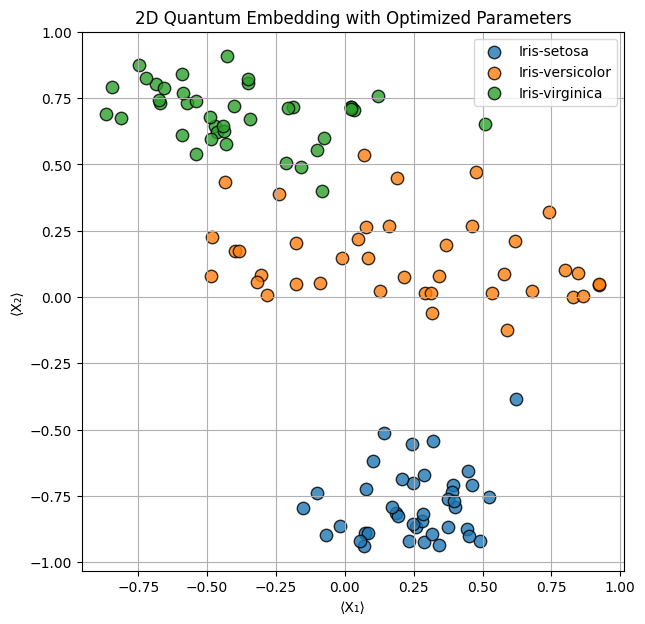

In [7]:
from scipy.optimize import minimize
import numpy as np

# Example: prepare states and breeds
states_and_breeds = list(zip(train_df.iloc[:, :4].values, train_df.iloc[:, 4].values))

# Flattened parameter vector for optimizer
num_layers = 4
num_qubits = 4
param_shape = (16 * num_layers, num_qubits)
initial_params = np.random.rand(*param_shape).flatten()  # optimizer uses 1D array

# Parameters
measurement_qubits = [1,2]
k = 10
a = 1.929
b = 0.7915

# Example: minimize using SciPy
res = minimize(
    quantum_umap_cost,   # function to minimize
    initial_params,            # flattened initial parameters
    args=(states_and_breeds, num_layers, measurement_qubits, k, a, b),  # extra arguments
    method='L-BFGS-B',
    options={'maxiter': 5}
)

optimized_params = res.x.reshape(16 * num_layers, num_qubits)
print("Optimized cost:", res.fun)

# Map states to 2D using optimized parameters
coords_2d, breeds = map_states_to_2d_with_labels(
    states_and_breeds, 
    params=optimized_params, 
    layers=num_layers, 
    measurement_qubits=[1,2]
)

coords_2d = np.array(coords_2d)
unique_breeds = np.unique(breeds)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_breeds)))

plt.figure(figsize=(7,7))
for breed, color in zip(unique_breeds, colors):
    mask = np.array(breeds) == breed
    plt.scatter(
        coords_2d[mask, 0], 
        coords_2d[mask, 1], 
        label=breed, 
        alpha=0.8, 
        edgecolors='k', 
        s=80
    )

plt.xlabel("⟨X₁⟩")
plt.ylabel("⟨X₂⟩")
plt.title("2D Quantum Embedding with Optimized Parameters")
plt.grid(True)
plt.legend()
plt.show()

### Test run with random params

### Training Loop